# Data Gathered From Quarterly Census of Employment and Wages

https://data.bls.gov/cew/apps/data_views/data_views.htm#tab=Tables

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#relative folder to data
path = "data"

Statistics are separated in different .csv files, let's aggregate them into one dataframe so it's easier to work with

In [3]:
#indicator if our dataframe is initialized or now
initialized = False

#load in each individual dataset and stack them 
for borough in ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]:
    
    #store dataset in df
    df = pd.read_csv(path + "/" +  borough + "_QCEW.csv")
    
    #add column to indicate which borough this dataset is from
    df["Borough"] = borough
    
    #if our stacked dataframe is not initialized, initalize it here
    if not initialized:
        summary = df
        initialized = True
    #otherwise stack on top of our existing dataframe
    else:
        summary = pd.concat([summary, df])

In [4]:
summary.head(5)

,Year,Quarter,Quarterly Establishments,Third Month Employment,Average Weekly Wage,Third Month Employment Location Quotient,Average Weekly Wage Location Quotient,Third Month Employment Change Over the Year,Third Month Employment % Change Over the Year,Average Weekly Wage Change Over the Year,Average Weekly Wage % Change Over the Year,Borough
0,2019,1,126261,2277539,3312,1.07,1.04,62354,0.028,59,0.018,Manhattan
1,2019,2,127518,2307608,2152,1.06,1.03,59655,0.027,89,0.043,Manhattan
2,2019,3,128008,2290778,2100,1.06,1.03,63164,0.028,58,0.028,Manhattan
3,2019,4,128628,2344341,2583,1.07,1.03,56223,0.025,111,0.045,Manhattan
4,2020,1,129964,2260365,3448,1.07,1.04,-17174,-0.008,136,0.041,Manhattan


Let's convert the Year and Quarter columns into a datetime column so we can plot it easier

In [5]:
# period index with year and quarter columns
periods = pd.PeriodIndex(year=summary['Year'], quarter=summary['Quarter'])

# convert period index timestamp
summary["Date"] = periods.to_timestamp()

# convert to datetime
summary['Date'] = pd.to_datetime(summary['Date'])

# drop the year and quarter columns 
summary = summary.drop(columns=['Year', 'Quarter'])



# Visualizations

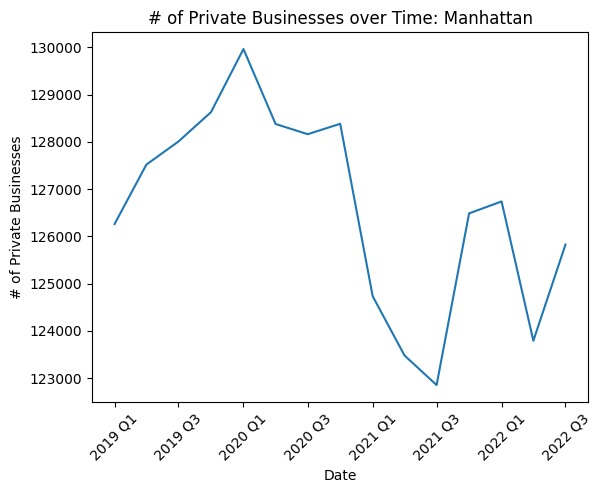

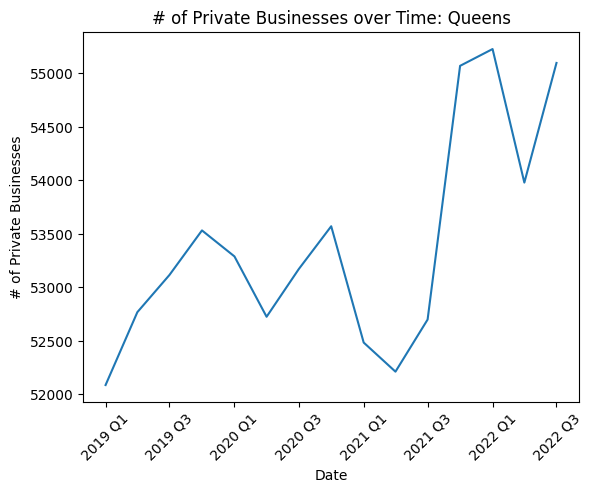

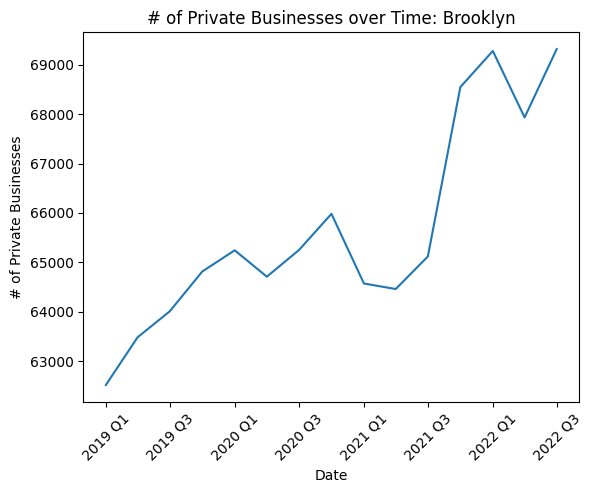

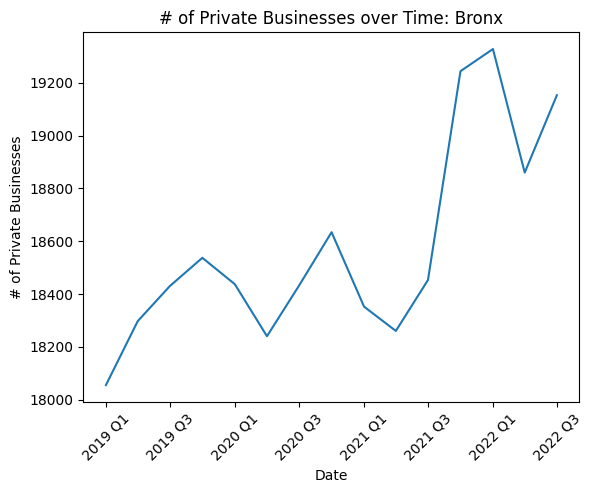

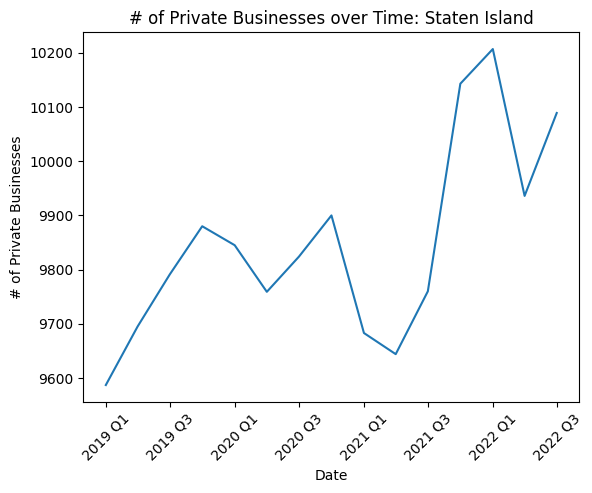

In [6]:
#plots # of private establishments over time for a given borough
def plot_establishments(df, borough):
    ax = sns.lineplot(x='Date', y= "Quarterly Establishments", data=summary[summary["Borough"] ==  borough])
    plt.title("# of Private Businesses over Time: %s" % borough)
    ax.set_xticks(["2019-01", "2019-07", "2020-01","2020-07", "2021-01", "2021-07", "2022-01", "2022-07"])
    ax.set_xticklabels(["2019 Q1", "2019 Q3", "2020 Q1", "2020 Q3", "2021 Q1", "2021 Q3", "2022 Q1", "2022 Q3"], rotation=45)
    plt.ylabel("# of Private Businesses")
    plt.savefig("output/QCEW_output/%s.png" % borough)
    plt.show()

#plot for each borough
for borough in ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]:
    plot_establishments(summary, borough)

    

In [7]:
#aggregate sum for all boroughs
total_grouped = summary.groupby("Date")["Quarterly Establishments"].agg(total = np.sum)
total_grouped.reset_index(inplace=True)

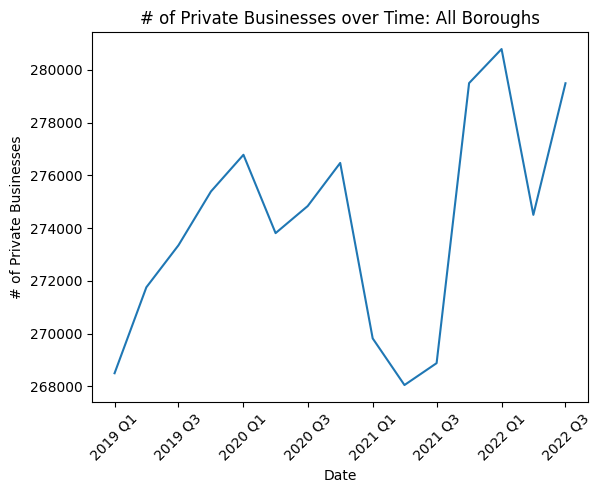

In [8]:
#plot # of private establishments over time for all boroughs
ax = sns.lineplot(x='Date', y= "total", data=total_grouped)
plt.title("# of Private Businesses over Time: All Boroughs")
ax.set_xticks(["2019-01", "2019-07", "2020-01","2020-07", "2021-01", "2021-07", "2022-01", "2022-07"])
ax.set_xticklabels(["2019 Q1", "2019 Q3", "2020 Q1", "2020 Q3", "2021 Q1", "2021 Q3", "2022 Q1", "2022 Q3"], rotation=45)
plt.ylabel("# of Private Businesses")
plt.savefig("output/QCEW_output/%s.png" % ("ALL"))
plt.show()


Since the scales for each borough are very different, let's instead look at a percent change from a static point in time

In [9]:
#initialize dataframe
pct_change = pd.DataFrame(columns = ["Date", "Quarterly Establishments",  "Borough"])

pd.options.mode.chained_assignment = None

for borough in ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]:
    
    #extract relevant info from this borough
    extract = summary[summary["Borough"] ==  borough][["Date", "Quarterly Establishments", "Borough"]]
    
    #cutoff data before 2019 Q4
    cutoff = pd.to_datetime('2019-10-01')
    extract_filtered = extract[extract['Date'] >= cutoff]
    
    #get total number of private estabishments from 2019 Q4
    beginning = float(extract_filtered[extract_filtered["Date"] == "2019-10-01"]["Quarterly Establishments"].iloc[0])

    #calculate percent change from 2019 Q4
    extract_filtered["PCT_Change"] =  ((extract_filtered['Quarterly Establishments'] - beginning) / beginning) * 100
    
    #calculate total change from 2019 Q4
    extract_filtered["Change"] =  extract_filtered['Quarterly Establishments'] - beginning
    
    #add on to our dataframe
    pct_change = pd.concat([pct_change,extract_filtered] , axis = 0)
    


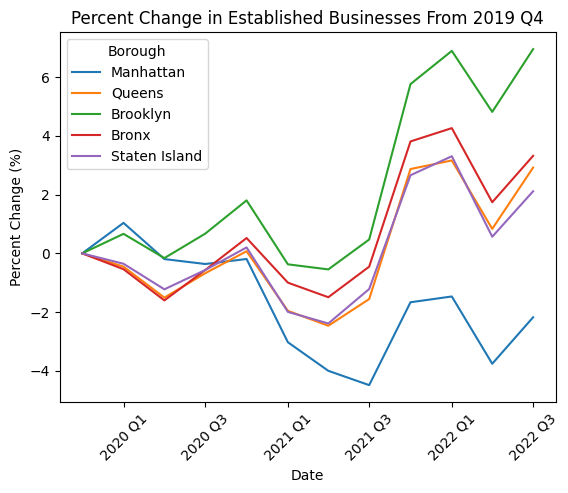

In [10]:
#plot percent change in private establishments over time for each borough
ax = sns.lineplot(x='Date', y= "PCT_Change", hue = "Borough", data=pct_change)
plt.title("Percent Change in Established Businesses From 2019 Q4")
ax.set_xticks(["2020-01","2020-07", "2021-01", "2021-07", "2022-01", "2022-07"])
ax.set_xticklabels(["2020 Q1", "2020 Q3", "2021 Q1", "2021 Q3", "2022 Q1", "2022 Q3"], rotation=45)
plt.ylabel("Percent Change (%)")
plt.savefig("output/QCEW_output/PCT_Change.png", bbox_inches='tight')
plt.show()

In [11]:
#save results to csv
pct_change.to_csv("output/QCEW_output/PrivateEstablishmentChange.csv", header=True, index=False)

In [12]:
#look at 2021 Q3 and 2022 Q3
pct_change[pct_change["Date"].isin(["2021-07-01", "2022-07-01"])]

,Date,Quarterly Establishments,Borough,PCT_Change,Change
10,2021-07-01,122854,Manhattan,-4.488914,-5774.0
14,2022-07-01,125827,Manhattan,-2.177597,-2801.0
10,2021-07-01,52700,Queens,-1.556050,-833.0
14,2022-07-01,55098,Queens,2.923430,1565.0
10,2021-07-01,65117,Brooklyn,0.472142,306.0
14,2022-07-01,69321,Brooklyn,6.958695,4510.0
10,2021-07-01,18453,Bronx,-0.453148,-84.0
14,2022-07-01,19153,Bronx,3.323084,616.0
10,2021-07-01,9760,Staten Island,-1.214575,-120.0
14,2022-07-01,10089,Staten Island,2.115385,209.0
